# Advanced Weather Data Analysis

This notebook performs advanced data analysis on a global weather dataset. The tasks include anomaly detection, forecasting with multiple models, and unique analyses like climate and environmental impact studies.

## Import Necessary Libraries

Import all required libraries upfront.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import geopandas as gpd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Load and Explore the Dataset

Loading the dataset and displaying the first few rows to understand its structure.


In [21]:
# Load the dataset
data = pd.read_csv("GlobalWeatherRepository.csv")

# Display the first few rows of the dataset
data.head()
data.isnull().sum()


country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

## Data Summary and Preliminary Visualizations

Provide a summary of the dataset and initial visualizations to understand the data distribution.


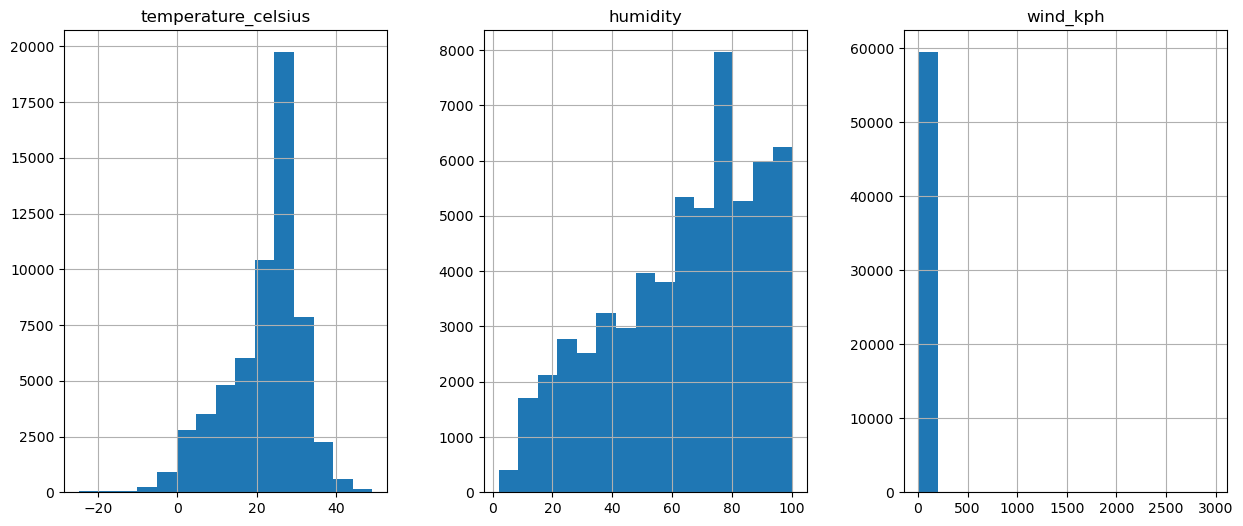

In [22]:
# Describe the data for an overview of statistical summaries
data.describe()

# Plot the distribution of key numerical features
numerical_features = ['temperature_celsius', 'humidity', 'wind_kph']
data[numerical_features].hist(bins=15, figsize=(15, 6), layout=(1, 3))
plt.show()


## Advanced EDA: Anomaly Detection

Implementing anomaly detection on temperature data using the Isolation Forest algorithm.


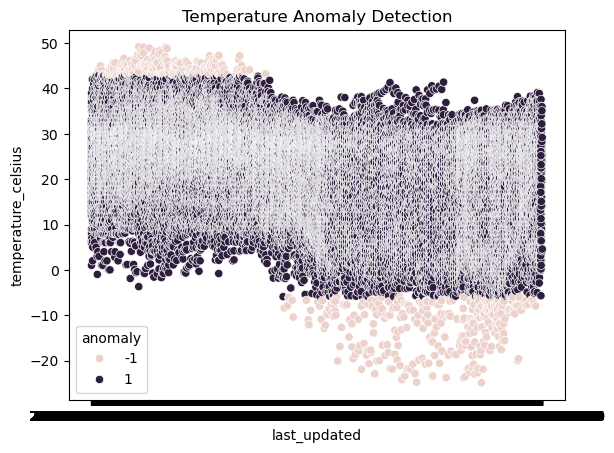

Number of anomalies detected: 581
Anomaly Temperature Statistics:
count    581.000000
mean      12.356799
std       28.401282
min      -24.900000
25%      -11.000000
50%       -6.900000
75%       44.100000
max       49.200000
Name: temperature_celsius, dtype: float64


In [23]:
# Anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.01)
data['anomaly'] = iso_forest.fit_predict(data[['temperature_celsius']])

# Visualizing anomalies in temperature
sns.scatterplot(data=data, x='last_updated', y='temperature_celsius', hue='anomaly')
plt.title('Temperature Anomaly Detection')
plt.show()

# Filter data for anomalies
anomalies = data[data['anomaly'] == -1]

# Display basic statistics and count of anomalies
print("Number of anomalies detected:", anomalies.shape[0])
print("Anomaly Temperature Statistics:")
print(anomalies['temperature_celsius'].describe())


## Forecasting with Multiple Models

Forecasting temperature using ARIMA and Prophet models and comparing their performance.


In [24]:
# --- Step 1: Ensure unique datetime index ---
data = data[~data.index.duplicated(keep='first')]  # Remove duplicate timestamps

# --- Step 2: Regenerate predictions with clean index ---
# Fit ARIMA (with cleaned data)
arima_model = ARIMA(data['temperature_celsius'].dropna(), order=(5,1,0))
arima_result = arima_model.fit()

# Generate ARIMA predictions with aligned index
arima_predictions = arima_result.predict(start=data.index[0], end=data.index[-1], typ='levels')

# Fit Prophet (with cleaned data)
df_prophet = data.reset_index()[['last_updated', 'temperature_celsius']].rename(
    columns={'last_updated': 'ds', 'temperature_celsius': 'y'}
)
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=365)
forecast_prophet = prophet_model.predict(future)

# Align Prophet predictions with cleaned data index
future['ds'] = pd.to_datetime(future['ds'])
prophet_predictions = forecast_prophet.set_index('ds')['yhat'].reindex(data.index, fill_value=np.nan)

# --- Step 3: Recalculate ensemble predictions ---
ensemble_predictions = (arima_predictions + prophet_predictions) / 2

# --- Step 4: Calculate RMSE with aligned data ---
def calculate_rmse(actual, predictions):
    combined = pd.DataFrame({'actual': actual, 'predictions': predictions}).dropna()
    return np.sqrt(mean_squared_error(combined['actual'], combined['predictions']))

rmse_arima = calculate_rmse(data['temperature_celsius'], arima_predictions)
rmse_prophet = calculate_rmse(data['temperature_celsius'], prophet_predictions)
rmse_ensemble = calculate_rmse(data['temperature_celsius'], ensemble_predictions)

# --- Step 5: Plotting ---
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temperature_celsius'], label='Actual')
plt.plot(data.index, arima_predictions, label='ARIMA Forecast', alpha=0.7)
plt.plot(data.index, prophet_predictions, label='Prophet Forecast', alpha=0.7)
plt.plot(data.index, ensemble_predictions, label='Ensemble Forecast', alpha=0.7)
plt.legend()
plt.title('Temperature Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.show()

print("RMSE ARIMA: ", rmse_arima)
print("RMSE Prophet: ", rmse_prophet)
print("RMSE Ensemble: ", rmse_ensemble)

18:58:33 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## Unique Analyses

### Climate Analysis

Analyzing long-term climate patterns using historical temperature data.


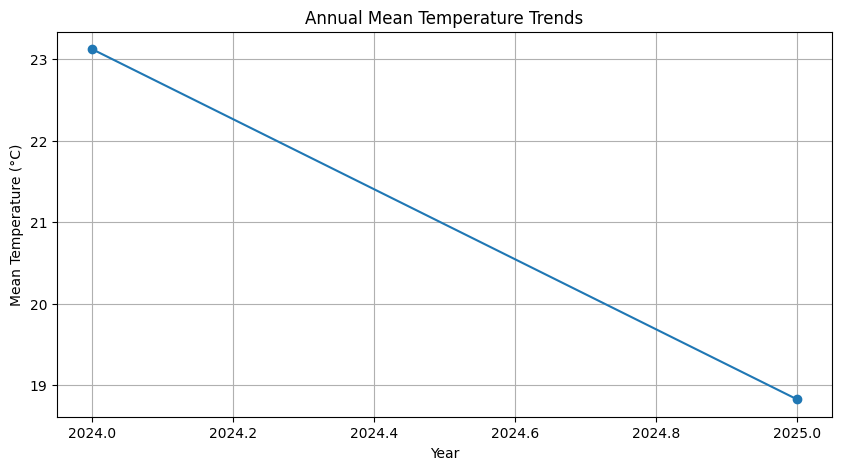

In [ ]:
# Climate trend analysis (corrected version)
data['year'] = data.index.year  # Extract year directly from the datetime index
annual_mean_temp = data.groupby('year')['temperature_celsius'].mean()

plt.figure(figsize=(10, 5))
plt.plot(annual_mean_temp.index, annual_mean_temp.values, marker='o')
plt.title('Annual Mean Temperature Trends')
plt.xlabel('Year')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.show()

### Environmental Impact Analysis

Analyzing the correlation between air quality indices and weather parameters.


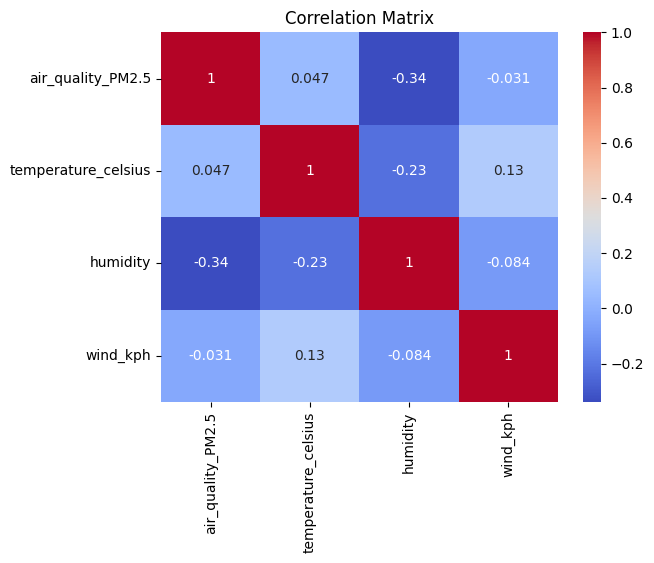

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrected attributes for the correlation matrix
correlation_features = ['air_quality_PM2.5', 'temperature_celsius', 'humidity', 'wind_kph']

# Creating the correlation matrix
sns.heatmap(data[correlation_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### Feature Importance in Weather Prediction

Using Random Forest to identify important features affecting temperature.


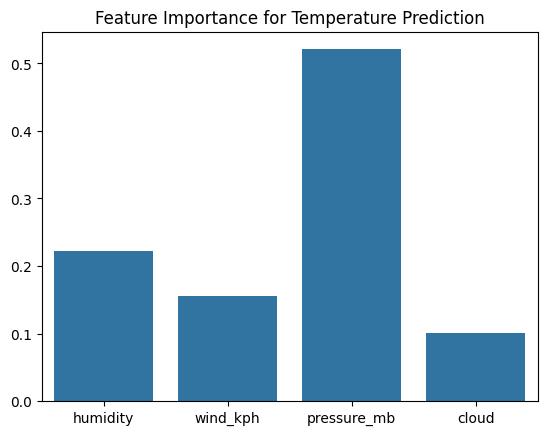

In [ ]:
# Corrected attributes for the feature importance calculation
features = ['humidity', 'wind_kph', 'pressure_mb', 'cloud']  # Adjusted to match the dataset
X = data[features]
y = data['temperature_celsius']

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X, y)
importance = rf.feature_importances_

# Plotting feature importance
sns.barplot(x=features, y=importance)
plt.title('Feature Importance for Temperature Prediction')
plt.show()

### Spatial Analysis of Weather Patterns

This analysis will visualize global temperature patterns using the GeoDataFrame.


In [ ]:
from google.colab import files
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

# Load the shapefile
world = gpd.read_file('ne_10m_admin_0_countries.shp')

# Assume 'data' is a DataFrame that's already loaded and contains latitude and longitude
# Create a GeoDataFrame
data['geometry'] = data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, column='temperature_celsius', cmap='coolwarm', legend=True,
         markersize=10, legend_kwds={'label': "Temperature (Celsius)",
                                     'orientation': "horizontal",
                                     'shrink': 0.5})
plt.title('Global Temperature Distribution')
plt.show()


DataSourceError: Unable to open /content/ne_10m_admin_0_countries.shx or /content/ne_10m_admin_0_countries.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

###  Geographical Patterns: Temperature Differences by Continent

This analysis will aggregate temperature data by continent and visualize these differences.

In [ ]:
continent_temp = gdf.dissolve(by='continent', aggfunc='mean')  # Adjust 'continent' to appropriate column if different

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
continent_temp.plot(ax=ax, column='temperature_celsius', cmap='coolwarm', legend=True,
                    legend_kwds={'label': "Average Temperature (Celsius)", 'orientation': "horizontal"})
plt.title('Average Temperature by Continent')
plt.show()